# Sequential Pattern Mining

In this notebook, we want to find statistically relevant patterns between data examples. We model the customer as a sequence of baskets.

In [1]:
#import the module in the parent folder
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import mylib
from mylib.dataloading import *
from mylib import utilities

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [3]:
import spmf

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
plt.style.use('seaborn')
params = {
    'figure.figsize': (15, 5),
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'axes.titlesize': 'x-large',
}
plt.rcParams.update(params)

We retrive the clean dataset obtained in *Data Preparation* phase (see notebook for more details).

In [6]:
print(CLEAN_DATASET_NAME)
df = load_customer_data(CLEAN_DATASET_NAME)
df.info()

customer_supermarket_clean.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 68148 entries, 0 to 541907
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   BasketID         68148 non-null  int64         
 1   BasketDate       68148 non-null  datetime64[ns]
 2   Sale             68148 non-null  float64       
 3   CustomerID       68148 non-null  int64         
 4   CustomerCountry  68148 non-null  object        
 5   ProdID           68148 non-null  object        
 6   ProdDescr        68148 non-null  object        
 7   Qta              68148 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 4.7+ MB


In [7]:
df.head()
print("# of customers: ", df["CustomerID"].nunique())

# of customers:  3755


In [8]:
df['ProdDescr'] = df['ProdDescr'].str.strip()
df['ProdID'] = df['ProdID'].str.strip()

### ProdID transformation
Since the algorithms from the SPMF library work with sorted numbers and our ProdID contains strings with letters 
we map each ID to a positive integer. We also create an inverted dictionary in order to easily find the original ProdID.

In [9]:
a = set(df['ProdID'])
dictionary = {}
for i, el in enumerate(a):
    dictionary[str(el)] = i+1
inverted_dictionary = {v: k for k, v in dictionary.items()}

In [10]:
df['ProdID'] = df['ProdID'].apply(lambda x : dictionary[x])
display(df.head(10))

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
0,536365,2010-12-01 08:26:00,2.55,17850,United Kingdom,174,WHITE HANGING HEART T-LIGHT HOLDER,6
1,536365,2010-12-01 08:26:00,3.39,17850,United Kingdom,377,WHITE METAL LANTERN,6
2,536365,2010-12-01 08:26:00,2.75,17850,United Kingdom,489,CREAM CUPID HEARTS COAT HANGER,8
3,536365,2010-12-01 08:26:00,3.39,17850,United Kingdom,426,KNITTED UNION FLAG HOT WATER BOTTLE,6
4,536365,2010-12-01 08:26:00,3.39,17850,United Kingdom,473,RED WOOLLY HOTTIE WHITE HEART.,6
6,536365,2010-12-01 08:26:00,4.25,17850,United Kingdom,202,GLASS STAR FROSTED T-LIGHT HOLDER,6
9,536368,2010-12-01 08:34:00,4.25,13047,United Kingdom,228,JAM MAKING SET WITH JARS,6
14,536367,2010-12-01 08:34:00,2.10,13047,United Kingdom,564,POPPY'S PLAYHOUSE BEDROOM,6
15,536367,2010-12-01 08:34:00,2.10,13047,United Kingdom,419,POPPY'S PLAYHOUSE KITCHEN,6
16,536367,2010-12-01 08:34:00,3.75,13047,United Kingdom,811,FELTCRAFT PRINCESS CHARLOTTE DOLL,8


### Customer Modeling
We model the customer as a sequence of baskets, we remove duplicates from each basket and sort the elements of each basket in lexicographic order required by the SPM algorithms.

In [11]:
prof = df.groupby(['CustomerID', 'BasketID'])['ProdID'].unique().reset_index()
prof = prof[['CustomerID', 'ProdID']].groupby('CustomerID')["ProdID"].apply(list).reset_index()
prof.columns = ['CustomerID', 'Sequence']
display(prof)

,CustomerID,Sequence
0,12347,"[[1272, 1181, 1115, 1192, 445, 888, 1323, 1358..."
1,12349,"[[244, 83, 1264, 1171, 228, 1308, 332, 593, 10..."
2,12350,"[[667, 433, 1101, 1042, 84]]"
3,12352,"[[375, 890, 863, 281, 925], [551, 1253], [551,..."
4,12353,[[734]]
...,...,...
3750,18280,"[[237, 1192, 888, 1227, 20, 1341]]"
3751,18281,[[237]]
3752,18282,"[[1244, 904], [568, 168, 926]]"
3753,18283,"[[174, 838], [41, 1145], [41, 1145, 120, 254, ..."


In [12]:
def dedup_and_sort(ll):
    """removes duplicate from a basket and sorts it"""
    def f(l):
        l.sort()
        return l
    return list(map(f, ll))

In [13]:
prof['Sequence'] = prof['Sequence'].apply(dedup_and_sort)
print(f'# sequences = {len(prof)}')
display(prof)

# sequences = 3755


,CustomerID,Sequence
0,12347,"[[25, 71, 199, 317, 445, 888, 1040, 1115, 1181..."
1,12349,"[[75, 83, 101, 228, 244, 272, 332, 354, 518, 5..."
2,12350,"[[84, 433, 667, 1042, 1101]]"
3,12352,"[[281, 375, 863, 890, 925], [551, 1253], [551,..."
4,12353,[[734]]
...,...,...
3750,18280,"[[20, 237, 888, 1192, 1227, 1341]]"
3751,18281,[[237]]
3752,18282,"[[904, 1244], [168, 568, 926]]"
3753,18283,"[[174, 838], [41, 1145], [41, 120, 254, 1145, ..."


### Customer Filtering

We filter out the customers with only one basket

In [14]:
filtered = prof['Sequence'].apply(lambda x : len(x) > 2)
filtered = prof[filtered]
prof = filtered
print(f'the new length of the profile is {len(prof)}')

the new length of the profile is 1537


In [15]:
SEQUENCE_FILENAME='sequence.txt'

We now convert the dataframe with the sequences in the format used by the SPMF library. The format is the following:  
Input file format is a text file where each line represents a sequence from a sequence database. Each item from a sequence is a positive integer and items from the same itemset within a sequence are separated by single space. Note that it is assumed that items within a same itemset are sorted according to a total order and that no item can appear twice in the same itemset. The value "-1" indicates the end of an itemset. The value "-2" indicates the end of a sequence (it appears at the end of each line).

In [16]:
def convert_and_save(serie, filename=SEQUENCE_FILENAME):
    """in the file format used by the spmf library:
        The value "-1" indicates the end of an itemset.
        The value "-2" indicates the end of a sequence"""    
    with open(filename, 'w') as f:
        for l in serie:
            s = ""
            for e in l:
                for j in e:
                    s += str(j) + " "
                s += "-1 "
            s += "-2\n"
            f.write(s)
            

In [17]:
convert_and_save(prof['Sequence'])

# Sequential Pattern Mining

### NOTE
SPM is a computational intensive activity. On some machines the library used may raise an error due to the fact the JVM uses too much heap mempry. If that happens just raise the minsup parameters by 0.01 until the error disappears.

In [18]:
def spmf_file_loader_and_parser(filename, with_prod_id=True, delete_file=False, splitter='-1 #SUP:', no_singletons=True):
    """read the output file produced by the SPM algorithms
    Parameters
    ----------
        filename     - name of the file.
        with_prod_id - flag indicating if replacing the fake id with the original one.
        delete_file  - if true delete the file after reading from it.
        splitter     - string where to split the file lines.
    """
    lines = None
    
    def strip_list(l):
        """strips all the elements in the list l"""
        return [x.strip() for x in l]
    
    with open(filename, 'r') as f:
        lines = f.readlines()
        lines = [ l.split(splitter) for l in lines ]
        lines = [ (a[0].strip(), a[1].strip()) for a in lines ]
        lines = [ (strip_list(a[0].split('-1')), a[1]) for a in lines ]
        
    #Reinserting ProdID
    if with_prod_id == True:
        def replace_id(lis):
            def replace_and_put_together(x):
                """replace values of the form 'aaa bbb'"""
                l = x.split(' ')
                l = [inverted_dictionary[int(x)] for x in l]
                return ' '.join(l)
            return [inverted_dictionary[int(x)] if len(x.split(' ')) ==1 else replace_and_put_together(x) for x in lis]
        lines = [ (replace_id(a[0]), a[1]) for a in lines]
    if delete_file:
        import os
        os.remove(filename)
    return lines

In [19]:
from mylib.utilities import Timer
timer = Timer()

In [20]:
from spmf import Spmf

In [21]:
patterns = {}

In [22]:
OUT = 'SPADE.txt'
args = [0.06]

SPADE = Spmf('SPADE', input_filename=SEQUENCE_FILENAME, output_filename=OUT, arguments=args)

timer.start('spade')
SPADE.run()
timer.stop()

patterns['spade'] = spmf_file_loader_and_parser(OUT, True, True)

>/home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/4.SequentialPatternMining/spmf.jar
=============  Algorithm - STATISTICS =============
 Total time ~ 57 ms
 Frequent sequences count : 153
 Join count : 280
 Max memory (mb):26.7064208984375
Content at file SPADE.txt




In [23]:
OUT = 'SPADE_PAR.txt'
args = [0.06]
# with 0.06 it raises JAVA_ERROR: Index out of bound on one machine running MacOs but works on the Ubuntu one, in
# case of error increase the value by 0.01 until the error disappears. The error is due to the fact the alg. uses too 
#much heap memory
SPADE_PAR = Spmf('SPADE_Parallelized', input_filename=SEQUENCE_FILENAME, output_filename=OUT, arguments=args)

timer.start('spade_par')
SPADE_PAR.run()
timer.stop()

patterns['spade_par'] = spmf_file_loader_and_parser(OUT, True, True)

>/home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/4.SequentialPatternMining/spmf.jar
=============  Algorithm - STATISTICS =============
 Total time ~ 1659 ms
 Frequent sequences count : 153
 Join count : 0
 Max memory (mb):243.71790313720703
Content at file SPADE_PAR.txt




In [24]:
OUT='CMSPADE.txt'
args = [0.06]

CM_SPADE_PAR = Spmf('CM-SPADE', input_filename=SEQUENCE_FILENAME, output_filename=OUT, arguments=args)

timer.start('cmspade')
CM_SPADE_PAR.run()
timer.stop()

patterns['cmspade'] = spmf_file_loader_and_parser(OUT, True, True)

>/home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/4.SequentialPatternMining/spmf.jar
=============  CM-SPADE -- Algorithm - STATISTICS =============
 Total time ~ 177 ms
 Frequent sequences count : 153
 Join count : 71
 Max memory (mb):35.72771453857422
Content at file CMSPADE.txt




In [25]:
OUT='GSP.txt'
args = [0.06]

GSP = Spmf('GSP', input_filename=SEQUENCE_FILENAME, output_filename=OUT, arguments=args)

timer.start('gsp')
GSP.run()
timer.stop()

patterns['gsp'] = spmf_file_loader_and_parser(OUT, True, True)

>/home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/4.SequentialPatternMining/spmf.jar
=============  Algorithm - STATISTICS =============
 Total time ~ 7332 ms
 Frequent sequences count : 153
 Max memory (mb):562.7855529785156




In [26]:
OUT='CLOFAST.txt'
args = [0.06]

CLOFAST = Spmf('CloFast', input_filename=SEQUENCE_FILENAME, output_filename=OUT, arguments=args)

timer.start('clofast')
CLOFAST.run()
timer.stop()

patterns['clofast'] = spmf_file_loader_and_parser(OUT, True, True, '-1 -2 #SUP:')

>/home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/4.SequentialPatternMining/spmf.jar
=============  Algorithm CloFast v2.29 - STATISTICS =============
Number of closed Patterns found : 153
  Pattern count : 153
  Pruned Pattern count : 0
Total time: 0.769 s 
Max memory (mb) : 189.49803161621094




In [27]:
OUT='BIDEPLUS.txt'
# with 0.06 it raises JAVA_ERROR: Index out of bound on one machine running MacOs but works on the Ubuntu one, in
# case of error increase the value by 0.01 until the error disappears. The error is due to the fact the alg. uses too 
#much heap memory
args = [0.06] 

BIDEPLUS = Spmf('BIDE+', input_filename=SEQUENCE_FILENAME, output_filename=OUT, arguments=args)

timer.start('bide+')
BIDEPLUS.run()
timer.stop()

patterns['bide+'] = spmf_file_loader_and_parser(OUT, True, True)

>/home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/4.SequentialPatternMining/spmf.jar
============  BIDE+ - SPMF 0.99c - 2016 - STATISTICS =====
 Total time ~ 454 ms
 Frequent sequences count : 153
 Max memory (mb) : 33.23341369628906
 minsup = 93 sequences.
 Pattern count : 153




In [28]:
algorithms = [k for k, t in timer.getValList()] 
times = [t for k, t in timer.getValList()]
fsc = [len(fsc_i) for fsc_i in list(patterns.values())]
# memory usage was computed as average on 20 runs (written by hand)
mems = [26.66, 247.38, 35.67, 562.76, 189.77, 33.22]
spm_results = {
    "Algorithm": algorithms,
    "Computational cost (ms)": times,
    "Frequent sequences count": fsc,
    "Max Memory (mb)": mems
}

In [29]:
spm_results_df = pd.DataFrame(spm_results)
#spm_results_df = spm_results_df.set_index("Algorithm")
display(spm_results_df)

,Algorithm,Computational cost (ms),Frequent sequences count,Max Memory (mb)
0,spade,613.857508,153,26.66
1,spade_par,2275.879622,153,247.38
2,cmspade,660.128117,153,35.67
3,gsp,7746.211529,153,562.76
4,clofast,1099.481583,153,189.77
5,bide+,765.447617,153,33.22


### Computational costs

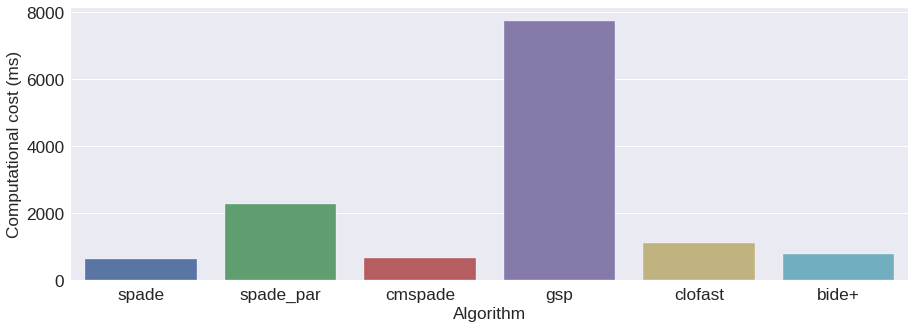

In [30]:
sns.barplot(x="Algorithm", y="Computational cost (ms)", data=spm_results_df)
plt.show()

### Frequent sequences counts

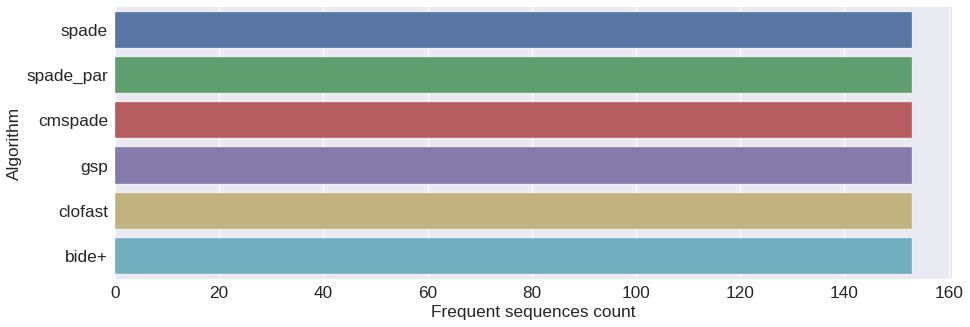

In [31]:
sns.barplot(y="Algorithm", x="Frequent sequences count", data=spm_results_df)
plt.show()

### Memory usage

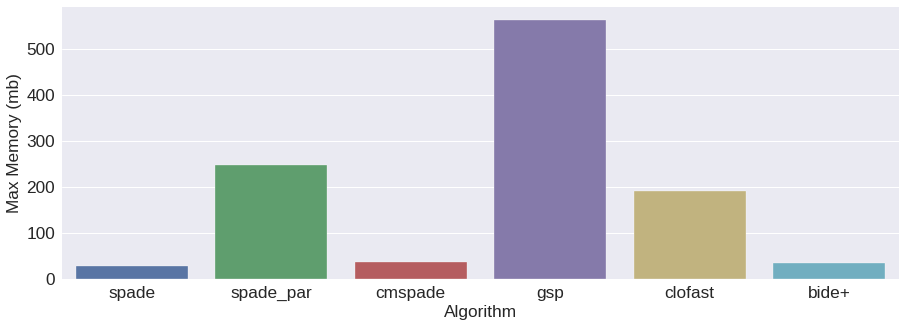

In [32]:
sns.barplot(x="Algorithm", y="Max Memory (mb)", data=spm_results_df)
plt.show()

Let's reset the original ProdID in the dataset.

In [33]:
df['ProdID'] = df['ProdID'].apply(lambda x : inverted_dictionary[x])

In [34]:
def remove_singletons(l, remove_support=True):
    """removes singletons from the patterns"""
    s = []
    for (a,b) in l:
        if len(a) > 1:
            s.append((a,b))
    s = s if remove_support == False else [a for (a,b) in s]
    return s

In [35]:
a = remove_singletons(patterns['bide+'])
a

[['23201', '85099B'],
 ['85123A', '85123A', '85123A'],
 ['85123A', '85123A'],
 ['22960', '22960'],
 ['22726', '22727'],
 ['22726', '22726'],
 ['23203', '23344'],
 ['23203', '23203'],
 ['23203', '85099B'],
 ['22457', '22457'],
 ['85099B', '23199'],
 ['85099B', '23344'],
 ['85099B', '23201'],
 ['85099B', '23203'],
 ['85099B', '23202'],
 ['85099B', '85099B'],
 ['85099B', '22386'],
 ['82482', '82494L'],
 ['82482', '82482'],
 ['82494L', '82494L'],
 ['22727', '22727'],
 ['22727', '22726'],
 ['22386', '23203'],
 ['22386', '22386'],
 ['22728', '22727']]

# SPM with temporal constraints

First we annotate the dataset with time information. The format that the SPMF library takes is documented below:  
Each line is a list of itemsets, where each itemset has a timestamp represented by a positive integer and each item is represented by a positive integer. Each itemset is first represented by it timestamp between the "<" and "> symbol. Then, the items of the itemset appear separated by single spaces. Finally, the end of an itemset is indicated by "-1". After all the itemsets, the end of a sequence (line) is indicated by the symbol "-2". Note that it is assumed that items are sorted according to a total order in each itemset and that no item appears twice in the same itemset.

First we replace the id's again.

In [36]:
df['ProdID'] = df['ProdID'].apply(lambda x : dictionary[x])

We create a timeseries of baskets with the time units being months.

In [37]:
df['Month'] = df['BasketDate'].dt.month
df['Year'] = df['BasketDate'].dt.year

We assign 0 to the first month to distinguish it from the same month of the following year

In [38]:
df.loc[(df['Month']==12) & (df['Year']==2010), 'Month'] = 0

This function performs the same basked grouping performed fot the SPM without temporal constraints but on a monthly basis so we'll have the baskets for each month.

In [39]:
def monthly_baskets(df, month):
    month_orders = df.loc[df['Month'] == month]
    o = month_orders.groupby(['CustomerID', 'BasketID'])['ProdID'].unique().reset_index()
    o = o[['CustomerID', 'ProdID']].groupby('CustomerID')["ProdID"].apply(list).reset_index()
    o.columns = ['CustomerID', str(month)]
    o[str(month)] = o[str(month)].apply(dedup_and_sort)
    return o

In [40]:
MONTHSRANGE = range(0,13)
monthly_baskets_list = [monthly_baskets(df, i) for i in MONTHSRANGE]

In [41]:
from functools import reduce
start = pd.DataFrame()
start['CustomerID'] = df['CustomerID'].unique()
baskets_time = reduce(lambda l, r: pd.merge(l, r, on='CustomerID', how='outer'), monthly_baskets_list).fillna('X')
baskets_time = pd.merge(start, baskets_time, on='CustomerID', how='outer').fillna('X')
print(len(baskets_time))
baskets_time.head(3)

3755


,CustomerID,0,1,2,3,4,5,6,7,8,9,10,11,12
0,17850,"[[174, 202, 377, 426, 473, 489], [174, 202, 37...",X,X,X,X,X,X,X,X,X,X,X,X
1,13047,"[[419, 564, 811, 1040], [228]]",X,"[[128, 228, 302, 344, 419, 512, 564, 811, 1040...","[[128, 174, 228, 639, 1040, 1308]]",X,"[[36, 46, 128, 204, 315, 421, 641, 1040, 1213]]","[[36, 75, 174, 272, 421, 549, 641, 787, 853, 9...",X,"[[75, 228, 787, 1064]]",X,"[[2, 8, 95, 228, 272, 528, 631, 752, 1199, 127...",X,X
2,12583,"[[293, 445]]","[[445, 888, 1199, 1323, 1358]]",[[615]],"[[437, 503, 1358]]",X,"[[423, 687, 1358]]","[[274], [437, 445, 888, 1323, 1358]]","[[442, 1323]]",[[498]],"[[171, 216, 274, 429, 445, 503, 615, 654, 674,...","[[654, 954]]","[[249, 441, 445, 606, 615, 1323], [503]]","[[56, 78, 257, 437, 498, 615, 954, 1199]]"


In [42]:
TIMED_SEQUENCE_FILENAME='timedsequence.txt'

In [43]:
def convert_and_save(serie, filename=SEQUENCE_FILENAME):
    """in the file format used by the spmf library:
        The value "-1" indicates the end of an itemset.
        The value "-2" indicates the end of a sequence"""    
    with open(filename, 'w') as f:
        for l in serie:
            s = ""
            for e in l:
                for j in e:
                    s += str(j) + " "
                s += "-1 "
            s += "-2\n"
            f.write(s)
            

We convert the transposed dataframe in the right format and save it to the file `timedsequence.txt`

In [44]:
MONTH_FORMATTER = "<{}> "
with open(TIMED_SEQUENCE_FILENAME, 'w') as f:
    for (columnName, columnData) in baskets_time.T.iteritems():
        customer_data = ""
        for i, baskets in enumerate(columnData[1:]):
            if type(baskets) is list:
                s = "<"+str(i)+"> "
                for basket in baskets:
                    s += ' '.join([str(k) for k in basket])
                    s += ' -1 '
                customer_data += s
        customer_data += '-2\n'
        f.write(customer_data)    

In [45]:
def spmf_timedfile_loader_and_parser(filename, with_prod_id=True, delete_file=False, splitter='#SUP: '):
    """read the output file produced by the SPM algorithms that use time annotations.
    Parameters
    ----------
        filename     - name of the file.
        with_prod_id - flag indicating if replacing the fake id with the original one.
        delete_file  - if true delete the file after reading from it.
        splitter     - string where to split the file lines.
    """
    lines = None
    
    def strip_list(l):
        """strips all the elements in the list l"""
        return [x.strip() for x in l]
    
    with open(filename, 'r') as f:
        lines = f.readlines()
        lines = [ e.strip().split(splitter) for e in lines]
        lines = [ (l.split('-1 '), int(r.strip())) for (l,r) in lines]
        res = []
        for (l, support) in lines:
            l = list(filter(lambda x : x != ' ', l))
            for e in l:
                s = e.replace('<', '').replace('>', '').strip().split(' ')
                if with_prod_id:
                    s[1:] = [inverted_dictionary[int(i)] for i in s[1:]]
                
                res.append((s, support))
                
    if delete_file:
        os.remove(filename)
    return res

## Algorithms

In [46]:
patterns_temp = {}

In [47]:
OUT='HIRATEYAMANA.txt'
# minsup mintimeinterval maxtimeinterval minwholetimeinterval maxwholetimeinterval
args = [0.06, 0, 12, 0, 13]

HIRATEYAMANA = Spmf('HirateYamana', input_filename=TIMED_SEQUENCE_FILENAME, output_filename=OUT, arguments=args)

timer.start('hirateyamana')
HIRATEYAMANA.run()
timer.stop()

patterns_temp['hirateyamana'] = spmf_timedfile_loader_and_parser(OUT, True, True)

>/home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/4.SequentialPatternMining/spmf.jar
=============  Algorithm - STATISTICS =============
 Total time ~ 304 ms
 Frequent sequences count : 27




In [48]:
OUT='FOURNIER.txt'
# minsup mintimeinterval maxtimeinterval minwholetimeinterval maxwholetimeinterval
args = [0.06, 0, 12, 0, 13]

FOURNIER = Spmf('Fournier08-Closed+time', input_filename=TIMED_SEQUENCE_FILENAME, output_filename=OUT, arguments=args)

timer.start('fournier')
FOURNIER.run()
timer.stop()

patterns_temp['fournier'] = spmf_timedfile_loader_and_parser(OUT, True, True)

>/home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/4.SequentialPatternMining/spmf.jar
=============  Algorithm - STATISTICS =============
 Total time ~ 748 ms
 Frequent sequences count : 27




In [49]:
patterns_temp['hirateyamana']

[(['0', '23202'], 243),
 (['0', '22865'], 230),
 (['0', '22386'], 241),
 (['0', '23199'], 226),
 (['0', '23084'], 289),
 (['0', '22411'], 229),
 (['0', '22149'], 237),
 (['0', '21181'], 232),
 (['0', '22727'], 254),
 (['0', '22697'], 267),
 (['0', '22960'], 410),
 (['0', '23203'], 344),
 (['0', '22457'], 445),
 (['0', '85099B'], 433),
 (['0', '82482'], 293),
 (['0', '22722'], 257),
 (['0', '23344'], 244),
 (['0', '22910'], 275),
 (['0', '22666'], 278),
 (['0', '21733'], 228),
 (['0', '22470'], 292),
 (['0', '22699'], 301),
 (['0', '82494L'], 271),
 (['0', '23201'], 257),
 (['0', '85123A'], 587),
 (['0', '23240'], 244),
 (['0', '22086'], 364)]

In [50]:
patterns_temp['fournier']

[(['0', '23202'], 243),
 (['0', '22865'], 230),
 (['0', '22386'], 241),
 (['0', '23199'], 226),
 (['0', '23084'], 289),
 (['0', '22411'], 229),
 (['0', '22149'], 237),
 (['0', '21181'], 232),
 (['0', '22727'], 254),
 (['0', '22697'], 267),
 (['0', '22960'], 410),
 (['0', '23203'], 344),
 (['0', '22457'], 445),
 (['0', '85099B'], 433),
 (['0', '82482'], 293),
 (['0', '22722'], 257),
 (['0', '23344'], 244),
 (['0', '22910'], 275),
 (['0', '22666'], 278),
 (['0', '21733'], 228),
 (['0', '22470'], 292),
 (['0', '22699'], 301),
 (['0', '82494L'], 271),
 (['0', '23201'], 257),
 (['0', '85123A'], 587),
 (['0', '23240'], 244),
 (['0', '22086'], 364)]

Both algorithms find the same patterns.

The products 85123A and 22457 have the higher a supports with values that are over 440. They correspond to the items:

In [51]:
from mylib.utilities import get_description_from_prodid
df['ProdID'] = df['ProdID'].apply(lambda x : inverted_dictionary[x])
print(get_description_from_prodid('85123A', df))
print(get_description_from_prodid('22457', df))
df['ProdID'] = df['ProdID'].apply(lambda x : dictionary[x])

WHITE HANGING HEART T-LIGHT HOLDER
NATURAL SLATE HEART CHALKBOARD


In [52]:
d_timer = dict(timer.getValList())

In [53]:
tc_algorithms = ["hirateyamana", "fournier"]
tc_times = [d_timer["hirateyamana"], d_timer["fournier"]]
tc_fsc = [len(fsc_i) for fsc_i in list(patterns_temp.values())]
tc_spm_results = {
    "Algorithm": tc_algorithms,
    "Computational cost (ms)": tc_times,
    "Frequent sequences count": tc_fsc
}

In [54]:
tc_spm_results_df = pd.DataFrame(tc_spm_results)
#spm_results_df = spm_results_df.set_index("Algorithm")
display(tc_spm_results_df)

,Algorithm,Computational cost (ms),Frequent sequences count
0,hirateyamana,748.977184,27
1,fournier,1220.066071,27


### Computational costs

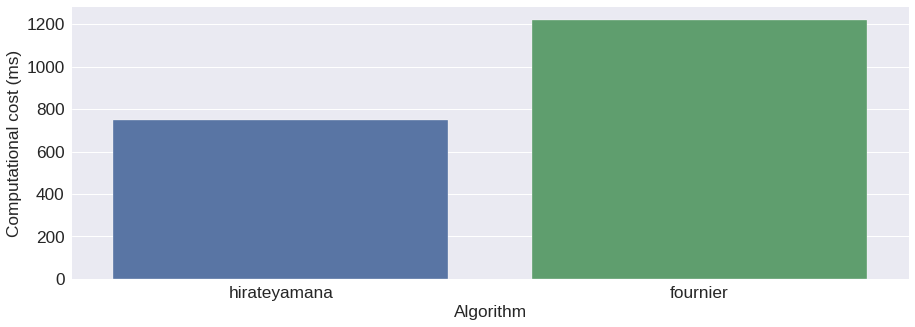

In [55]:
sns.barplot(x="Algorithm", y="Computational cost (ms)", data=tc_spm_results_df)
plt.show()

We explored all the combinations of patterns for mintimeinterval maxtimeinterval minwholetimeinterval maxwholetimeinterval but never found sequential patterns with more itemsets so all the found patterns have timestamp 0 since the algorithms assigns relative timestamps to the itemsets starting from 0 and then assigning the timeunits of distance to the others itemsets.

### Frequent sequences counts

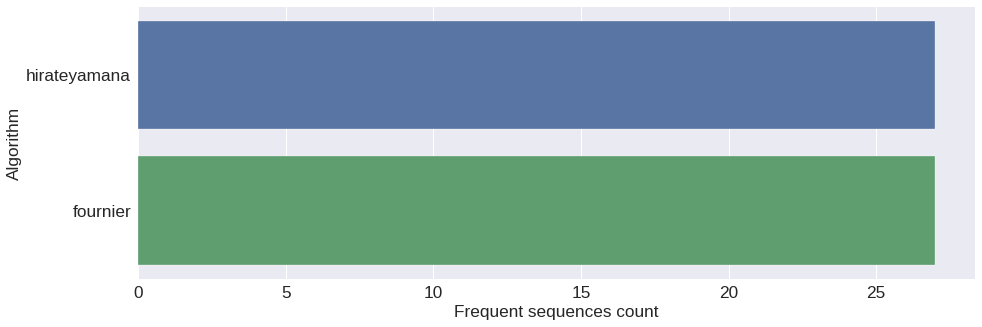

In [56]:
sns.barplot(y="Algorithm", x="Frequent sequences count", data=tc_spm_results_df)
plt.show()

# Interesting Patterns

With an high value of minsup, above the 25% no frequent patterns emerge. Here we show the patterns found by the fastest algorithm CMSPADE with a threshold of 25%. With this high tresholds the results provided by the various algorithms are virtually identical.

Here we show the results obtained by CMSPADE and SPADE. They are identical and CMSPADE is a bit faster.

In [57]:
OUT='CMSPADE_5.txt'
args = [0.25]

CM_SPADE_PAR = Spmf('CM-SPADE', input_filename=SEQUENCE_FILENAME, output_filename=OUT, arguments=args)

timer.start('cmspade')
CM_SPADE_PAR.run()
timer.stop()

cmspade = spmf_file_loader_and_parser(OUT, True, True)
cmspade

>/home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/4.SequentialPatternMining/spmf.jar
=============  CM-SPADE -- Algorithm - STATISTICS =============
 Total time ~ 4 ms
 Frequent sequences count : 1
 Join count : 0
 Max memory (mb):18.809188842773438
Content at file CMSPADE_5.txt




[(['85123A'], '390')]

In [58]:
OUT = 'SPADE_05.txt'
args = [0.25]

SPADE = Spmf('SPADE', input_filename=SEQUENCE_FILENAME, output_filename=OUT, arguments=args)

timer.start('spade')
SPADE.run()
timer.stop()

spade = spmf_file_loader_and_parser(OUT, True, True)
spade

>/home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/4.SequentialPatternMining/spmf.jar
=============  Algorithm - STATISTICS =============
 Total time ~ 7 ms
 Frequent sequences count : 1
 Join count : 1
 Max memory (mb):18.817138671875
Content at file SPADE_05.txt




[(['85123A'], '390')]

To find what this frequent items are, first we reinsert the original ids in the DataFrame and then we retrieve the description.

In [59]:
df['ProdID'] = df['ProdID'].apply(lambda x : inverted_dictionary[x])

In [60]:
from mylib.utilities import get_description_from_prodid
print(get_description_from_prodid(spade[0][0][0], df))

WHITE HANGING HEART T-LIGHT HOLDER


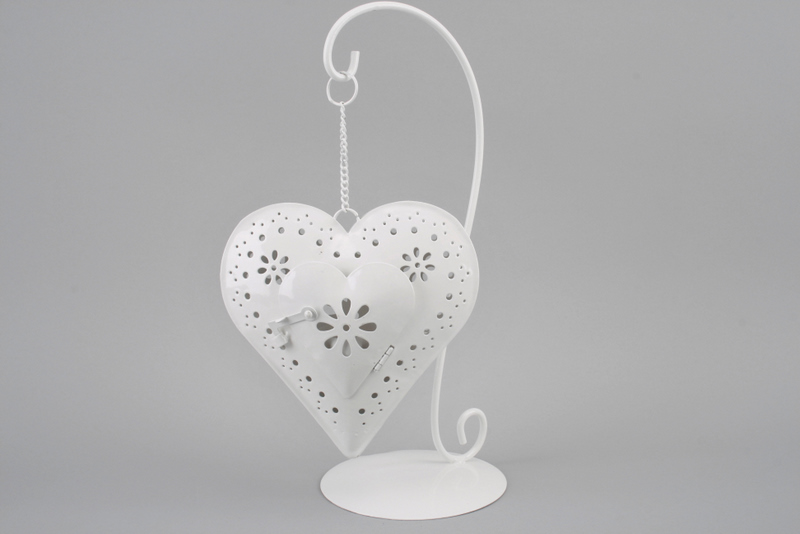

In [61]:
from IPython.display import Image
Image(filename="products_imgs/candleholder.jpg", width=300)

# Less frequent but interesting patterns

We use the patterns found by CMSPADE

In [62]:
patterns_cm = remove_singletons(patterns['cmspade'])
print(f"there are {len(patterns_cm)} non singletons")

there are 25 non singletons


Let's replace the ProdID with the ProdDescr so we can interpret the data.

In [63]:
def replacing_function(s:str):
    s = s.split(' ')
    if len(s) == 1:
        return get_description_from_prodid(s[0], df)
    else:
        l = list(map(lambda x: get_description_from_prodid(x, df), s))
        return ' | '.join(l)
rf = replacing_function

In [64]:
patterns_cm = list(filter(lambda x : x[0] != x[1],  patterns_cm))
patterns_cm = [ [rf(x[0]), rf(x[1])] for x in patterns_cm]
patterns_cm

[['ALARM CLOCK BAKELIKE PINK', 'ALARM CLOCK BAKELIKE RED'],
 ['JUMBO BAG RED RETROSPOT', 'JUMBO BAG VINTAGE LEAF'],
 ['JUMBO BAG RED RETROSPOT', "JUMBO BAG 50'S CHRISTMAS"],
 ['JUMBO BAG DOILEY PATTERNS', "JUMBO BAG 50'S CHRISTMAS"],
 ['JUMBO BAG RED RETROSPOT', 'JUMBO BAG APPLES'],
 ['JUMBO BAG RED RETROSPOT', 'JUMBO BAG PINK POLKADOT'],
 ['JUMBO BAG PINK POLKADOT', 'JUMBO BAG DOILEY PATTERNS'],
 ['ALARM CLOCK BAKELIKE GREEN', 'ALARM CLOCK BAKELIKE RED'],
 ['ALARM CLOCK BAKELIKE RED', 'ALARM CLOCK BAKELIKE GREEN'],
 ['WOODEN PICTURE FRAME WHITE FINISH', 'WOODEN FRAME ANTIQUE WHITE'],
 ['JUMBO BAG DOILEY PATTERNS', 'JUMBO BAG RED RETROSPOT'],
 ['JUMBO BAG RED RETROSPOT', 'JUMBO BAG DOILEY PATTERNS'],
 ['JUMBO BAG ALPHABET', 'JUMBO BAG RED RETROSPOT'],
 ['JUMBO BAG RED RETROSPOT', 'JUMBO BAG ALPHABET']]

We find that most of these non singleton sequential patterns are formed by the same product but with different color or different pattern printed on it.

# SPM on high spending customers

We reload the dataset to undo the changes and merge it with the annotated one in order to separate the customers based on their spending.

In [65]:
print(CLEAN_DATASET_NAME)
df = load_customer_data(CLEAN_DATASET_NAME)
df.info()

customer_supermarket_clean.csv
<class 'pandas.core.frame.DataFrame'>
Int64Index: 68148 entries, 0 to 541907
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   BasketID         68148 non-null  int64         
 1   BasketDate       68148 non-null  datetime64[ns]
 2   Sale             68148 non-null  float64       
 3   CustomerID       68148 non-null  int64         
 4   CustomerCountry  68148 non-null  object        
 5   ProdID           68148 non-null  object        
 6   ProdDescr        68148 non-null  object        
 7   Qta              68148 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(3)
memory usage: 4.7+ MB


We load the annotated dataset

In [66]:
print(ANNOTATED_CUSTOMER_PROFILE)
ann = load_customer_data(ANNOTATED_CUSTOMER_PROFILE)
ann = ann[['CustomerID', 'Spending']]
ann

annotated_customer_profile.csv


,CustomerID,Spending
0,12347,high
1,12349,med
2,12350,low
3,12352,high
4,12353,low
...,...,...
3750,18280,low
3751,18281,low
3752,18282,med
3753,18283,high


Let's join the dataframe and then select only the high spending customers

In [67]:
d = pd.merge(df, ann, on='CustomerID', how='outer').fillna(0)
df = d.loc[d['Spending'] == 'high']
df

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,Spending
130,536368,2010-12-01 08:34:00,4.25,13047,United Kingdom,22960,JAM MAKING SET WITH JARS,6,high
131,536367,2010-12-01 08:34:00,2.10,13047,United Kingdom,22745,POPPY'S PLAYHOUSE BEDROOM,6,high
132,536367,2010-12-01 08:34:00,2.10,13047,United Kingdom,22748,POPPY'S PLAYHOUSE KITCHEN,6,high
133,536367,2010-12-01 08:34:00,3.75,13047,United Kingdom,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,high
134,536367,2010-12-01 08:34:00,4.25,13047,United Kingdom,84969,BOX OF 6 ASSORTED COLOUR TEASPOONS,6,high
...,...,...,...,...,...,...,...,...,...
67741,578520,2011-11-24 13:57:00,2.08,14591,United Kingdom,23214,JINGLE BELL HEART ANTIQUE GOLD,4,high
67742,578520,2011-11-24 13:57:00,1.95,14591,United Kingdom,22187,GREEN CHRISTMAS TREE CARD HOLDER,9,high
67743,578520,2011-11-24 13:57:00,2.08,14591,United Kingdom,21930,JUMBO STORAGE BAG SKULLS,10,high
67744,578520,2011-11-24 13:57:00,2.08,14591,United Kingdom,22386,JUMBO BAG PINK POLKADOT,10,high


In [68]:
df.head()
print("# of customers: ", df["CustomerID"].nunique())

# of customers:  972


In [69]:
df['ProdDescr'] = df['ProdDescr'].str.strip()
df['ProdID'] = df['ProdID'].str.strip()

/home/fabsam/miniconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/fabsam/miniconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# ProdID transformation
(as before)

In [70]:
df['ProdID'] = df['ProdID'].apply(lambda x : dictionary[x])
display(df.head(10))

/home/fabsam/miniconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,Spending
130,536368,2010-12-01 08:34:00,4.25,13047,United Kingdom,228,JAM MAKING SET WITH JARS,6,high
131,536367,2010-12-01 08:34:00,2.10,13047,United Kingdom,564,POPPY'S PLAYHOUSE BEDROOM,6,high
132,536367,2010-12-01 08:34:00,2.10,13047,United Kingdom,419,POPPY'S PLAYHOUSE KITCHEN,6,high
133,536367,2010-12-01 08:34:00,3.75,13047,United Kingdom,811,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,high
134,536367,2010-12-01 08:34:00,4.25,13047,United Kingdom,1040,BOX OF 6 ASSORTED COLOUR TEASPOONS,6,high
135,543113,2011-02-03 13:06:00,2.95,13047,United Kingdom,302,PHOTO FRAME CORNICE,8,high
136,543113,2011-02-03 13:06:00,2.55,13047,United Kingdom,344,SET OF 12 VINTAGE POSTCARD SET,6,high
137,543113,2011-02-03 13:06:00,2.55,13047,United Kingdom,512,SET OF 6 VINTAGE NOTELETS KIT,6,high
138,543113,2011-02-03 13:06:00,3.95,13047,United Kingdom,1308,SET OF 6 SPICE TINS PANTRY DESIGN,4,high
139,543113,2011-02-03 13:06:00,4.25,13047,United Kingdom,228,JAM MAKING SET WITH JARS,6,high


# Customer Modeling
We model the customer as a sequence of baskets, we remove duplicates from each basket and sort the elements of each basket in lexicographic order required by the SPM algorithms.

In [71]:
prof = df.groupby(['CustomerID', 'BasketID'])['ProdID'].unique().reset_index()
prof = prof[['CustomerID', 'ProdID']].groupby('CustomerID')["ProdID"].apply(list).reset_index()
prof.columns = ['CustomerID', 'Sequence']
display(prof)

,CustomerID,Sequence
0,12347,"[[1272, 1181, 1115, 1192, 445, 888, 1323, 1358..."
1,12352,"[[375, 890, 863, 281, 925], [551, 1253], [551,..."
2,12360,"[[539, 558, 793, 1300, 953, 636, 985, 615, 437..."
3,12362,"[[293, 793, 1074, 1180, 515, 853, 509, 745, 13..."
4,12370,"[[427, 986, 830, 1000, 518, 332, 125, 924, 477..."
...,...,...
967,18241,"[[174, 1084, 482, 550, 116], [204, 576], [576,..."
968,18245,"[[569, 672, 174, 795, 917, 445, 1323, 840], [4..."
969,18257,"[[482, 1338, 1308, 593], [243], [206, 8, 787, ..."
970,18272,"[[266, 83, 67, 135, 107, 599, 1171, 1084, 228,..."


In [72]:
# tried from len 1 to 15
filtered = prof['Sequence'].apply(lambda x : len(x) > 15)
filtered = prof[filtered]
prof = filtered
print(f'the new length of the profile is {len(prof)}')

the new length of the profile is 86


In [73]:
prof['Sequence'] = prof['Sequence'].apply(dedup_and_sort)
print(f'# sequences = {len(prof)}')
display(prof)

# sequences = 86


,CustomerID,Sequence
25,12471,"[[30, 419, 564, 615, 781, 883, 1027], [461, 53..."
27,12474,"[[823], [441, 615, 930, 1223], [25, 71, 237, 4..."
46,12540,"[[473, 1034, 1055], [13, 40, 92, 404, 542, 580..."
51,12569,"[[92, 734, 1286], [92], [80, 734, 1095, 1218],..."
61,12621,"[[606, 705, 888, 1192, 1320], [228, 329], [281..."
...,...,...
919,17811,"[[13], [409, 612], [1341], [218, 712, 1014, 12..."
922,17841,"[[1034, 1289], [661, 1289], [40], [1049], [40,..."
926,17865,"[[117, 187, 356, 473, 494, 512, 541, 640, 656,..."
943,18109,"[[537], [537], [537], [344], [174, 548], [174]..."


In [74]:
SEQUENCE_FILENAME='sequence_highspending.txt'

In [75]:
convert_and_save(prof['Sequence'], SEQUENCE_FILENAME)

# Sequential Pattern Mining on high spending customers

In [76]:
OUT='CMSPADE_HIGH.txt'
args = [0.3]

CM_SPADE_PAR = Spmf('CM-SPADE', input_filename=SEQUENCE_FILENAME, output_filename=OUT, arguments=args)

timer.start('cmspade')
CM_SPADE_PAR.run()
timer.stop()

patterns['cmspade_highsp'] = spmf_file_loader_and_parser(OUT, True, True)
patterns['cmspade_highsp']

>/home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/4.SequentialPatternMining/spmf.jar
=============  CM-SPADE -- Algorithm - STATISTICS =============
 Total time ~ 12 ms
 Frequent sequences count : 16
 Join count : 6
 Max memory (mb):13.424072265625
Content at file CMSPADE_HIGH.txt




[(['21929'], '29'),
 (['23201'], '27'),
 (['85123A'], '27'),
 (['21928'], '27'),
 (['22960'], '28'),
 (['23203'], '33'),
 (['85099B'], '36'),
 (['21931'], '27'),
 (['85099F'], '26'),
 (['22090'], '30'),
 (['22386'], '30'),
 (['23199'], '28'),
 (['23202'], '28'),
 (['85099B', '85099B'], '27'),
 (['85099B', '23203'], '28'),
 (['23203', '23203'], '26')]

We don't obtain better results in terms of patterns found. In the following, we want to understand the reason.

In [77]:
def compute(l):
    s = 0
    for i in l:
        s = s + len(i)
    return int(s / len(l))

In [78]:
lenn = prof["Sequence"].apply(lambda x: compute(x))

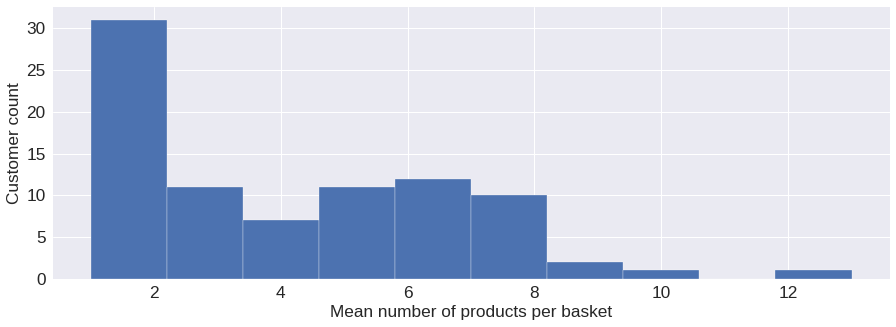

In [79]:
plt.hist(lenn)
plt.xlabel("Mean number of products per basket")
plt.ylabel("Customer count")
plt.show()

As expected, most of the customers have a shopping session with less then 10 items.